# Modern Portfolio Theory & Backward-Looking Mean-Variance Portfolio Optimization

For the first weighting model in this directory of notebooks, I will be starting easy with regular Mean-Variance Optimization (MVO) using historical data to calculate my expected asset returns / cov. matrices / std. deviations.

Mean-Variance Optimization is basically a method of calculating portfolio weights employing the assumption that it is efficient to minimize volatility given an expected return or maximize returns for a given level of volatility. Optically, this is very rational. Practically, estimating expected returns is quite difficult and it is arguably irrational to use historical ER as a baseline or predictor when you believe you have a differentiated thesis in the asset you'd like to weight. Estimating covariance matrices can also be quite difficult and becomes increasingly inaccurate the more correlated your basket of assets is.

I don't particularly like the idea of using MVO like this because of the overbearing reliance on historical data, but I am going to run this nonetheless for practice and to try generating some ideas on how it can be made better.

___________

**Table of Contents:**

- Step 1: Get historical data on portfolio basket asset returns

- Step 2: Clean data & compute weekly returns

- Step 3: Initialize optimization parameters

- Step 4: Compute historical mean expected returns, covariance, & precision matrices

- Step 5: Simulate portfolios

- Step 6: Evaluation of portfolios & identification of optimal portfolio from various standpoints

- Closing thoughts

In [51]:
# imports

import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import uniform
from scipy.optimize import minimize
from numpy.linalg import inv
import pandas_datareader.data as web
from numpy.random import random, uniform, dirichlet, choice

**Step 1: Get historical data on portfolio basket returns**

We will be using the iShares S&P 100 ETF (OEF) from the years 2012 - 2022 as our portfolio.

In [2]:
# Get the list of constituents in the S&P 100 index
sp100_constituents = pd.read_html("https://en.wikipedia.org/wiki/S%26P_100")[2]
tickers = sp100_constituents['Symbol'].tolist()

# Define the start and end dates for the historical data
start_date = "2012-01-01"
end_date = "2022-12-31"

# Create a dictionary to store the historical data for each stock
stock_data_dict = {}

# Fetch historical data for each stock
for ticker in tickers:
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval="1wk")  # Weekly data
        stock_data_dict[ticker] = stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

sample_ticker = tickers[0]
print(stock_data_dict[sample_ticker].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

**Step 2: Clean data & compute weekly returns**

In [23]:
# We can condense all these dataframes into a single one with the same date range and the assets as columns

# Create a new dataframe with the date range
all_weekly_dates = pd.date_range(start_date, end_date, freq="W")
all_weekly_dates_df = pd.DataFrame(all_weekly_dates, columns=['Date'])

# Set the date as the index
all_weekly_dates_df.set_index('Date', inplace=True)

# Add the tickers as columns
for ticker in tickers:
    all_weekly_dates_df[ticker] = np.nan

# Fill the dataframe with the adjusted close prices
for ticker in tickers:
    ticker_df = stock_data_dict[ticker]
    ticker_df = ticker_df[['Adj Close']]
    ticker_df.rename(columns={'Adj Close': ticker}, inplace=True)
    all_weekly_dates_df.update(ticker_df)

# Drop the cols with all NaN values
all_weekly_dates_df.dropna(axis=1, how='any', inplace=True)
all_weekly_dates_df.head()

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_58770/2182001659.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_weekly_dates_df[ticker] = np.nan
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_58770/2182001659.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df.rename(columns={'Adj Close': ticker}, inplace=True)
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_58770/2182001659.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

,AAPL,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,12.787853,21.054647,41.559456,28.719999,18.709417,5.43,47.778477,47.799423,9.1305,20.798609,...,21.597067,44.088924,41.662018,50.970245,19.426767,23.114237,21.598354,20.512831,45.591663,52.559891
2012-01-08,12.709444,20.892570,42.698063,28.969999,19.830074,5.66,49.873760,49.441654,8.9210,23.193644,...,22.445580,44.022114,42.514389,51.441933,20.322851,23.121124,22.216063,20.987728,46.008934,52.411697
2012-01-15,12.724277,21.198301,44.750786,30.500000,20.386427,6.42,51.327190,48.799030,9.5465,24.839308,...,24.396418,43.662907,43.719345,52.315929,20.119825,23.084402,22.244606,21.646915,47.144878,54.023319
2012-01-22,13.541080,20.916973,45.239902,31.049999,20.068508,6.82,50.419704,49.989048,9.7685,24.964199,...,23.649450,42.618748,44.517479,52.746006,19.503775,23.192270,21.239973,20.980637,46.913052,52.998310
2012-01-29,13.916481,20.909376,46.755390,31.850000,21.594519,7.08,51.113213,50.274654,9.3840,25.809072,...,24.736689,42.861000,44.986286,53.203819,20.441864,24.564766,21.599583,21.710709,47.933064,52.436394


In [25]:
# Make a dataframe of the monthly returns
all_weekly_returns_df = all_weekly_dates_df.pct_change()
all_weekly_returns_df.dropna(axis=0, how='any', inplace=True)
all_weekly_returns_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 2012-01-08 to 2022-12-25
Data columns (total 95 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    573 non-null    float64
 1   ABT     573 non-null    float64
 2   ACN     573 non-null    float64
 3   ADBE    573 non-null    float64
 4   AIG     573 non-null    float64
 5   AMD     573 non-null    float64
 6   AMGN    573 non-null    float64
 7   AMT     573 non-null    float64
 8   AMZN    573 non-null    float64
 9   AVGO    573 non-null    float64
 10  AXP     573 non-null    float64
 11  BA      573 non-null    float64
 12  BAC     573 non-null    float64
 13  BK      573 non-null    float64
 14  BKNG    573 non-null    float64
 15  BLK     573 non-null    float64
 16  BMY     573 non-null    float64
 17  C       573 non-null    float64
 18  CAT     573 non-null    float64
 19  CHTR    573 non-null    float64
 20  CL      573 non-null    float64
 21  CMCSA   573 non-null

**Step 3: Initialize Optimization Parameters**

In [47]:
n_obs, n_assets = all_weekly_returns_df.shape
print(n_obs, n_assets)

simulations = 10000

x0 = uniform(loc=0, scale=1).rvs(size=n_assets)
x0 /= np.sum(np.abs(x0))

periods_per_year = round(all_weekly_returns_df.resample('A').size().mean())
print(periods_per_year)

573 95
52


In [49]:
"""
Mean returns matrix

This is used as the Expected Returns for MVO
"""
mean_returns = all_weekly_returns_df.mean()

"""
Covariance matrix

This is used to model the historical volatility and correlation between assets in the S&P 100
"""
cov_matrix = all_weekly_returns_df.cov()

"""
Precision matrix (omega)

This is the inverse of the covariance matrix and is used to represent the concentration of the dist of asset returns.
To be honest, I don't really fully understand how this is used but it is required nonetheless.
"""
precision_matrix = pd.DataFrame(inv(cov_matrix.values), index=cov_matrix.index, columns=cov_matrix.columns)

In [50]:
# Get a vector of the historical risk free rates

start = '2012-01-01'
end = '2022-12-31'

treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

treasury_10yr_monthly
rfr = treasury_10yr_monthly.mean()

**Step 4: Simulate portfolios**

This is the fun part where we get to simulate thousands of random portfolios. We will use these to find the "optimal x" portfolio with a couple different x's:

- Sharpe
- Volatility

Basically what we are going to do here is create thousands of randomly weighted portfolios (using a Dirichlet distribution), compute their implied returns given their weights, then calculate the sharpe and vol statistics on those portfolios so we can easily sift through them later.

The option for 'short' has been left open but I will not be using it. If set to true, random weights can be given negative values to construct long/short portfolios. For now, we will just be simulating a long-only weight permutation on the S&P 100.

In [63]:
# Courtesy of Stefan Jansen, ML4T 2

def simulate_portfolios(mean_ret, cov, rf_rate=rfr, short=False):
    # alpha: array of n assets filled with the fill_value (parameter used by dirichlet)
    alpha = np.full(shape=n_assets, fill_value=.05)
    # weights: array of n_assets x simulations with the random dirichlet weights
    weights = dirichlet(alpha=alpha, size=simulations)
    # see above
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    # calc returns for each portfolio
    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    # std: used for volatilty
    std = (weights @ all_weekly_returns_df.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [64]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [65]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,1.021841e-02,1.077730e-02,1.097952e-02,9.915579e-03,1.054770e-02,1.110500e-02,1.022990e-02,1.012701e-02,1.106648e-02,1.036077e-02,...,1.101645e-02,1.071036e-02,1.036569e-02,1.000305e-02,1.020287e-02,1.133675e-02,9.949516e-03,1.051276e-02,1.069467e-02,1.087904e-02
std,4.248133e-02,4.387178e-02,4.419544e-02,4.081742e-02,4.214554e-02,4.383655e-02,4.137851e-02,4.398676e-02,4.463927e-02,4.207222e-02,...,4.537846e-02,4.291103e-02,4.163733e-02,4.038795e-02,4.172974e-02,4.596379e-02,3.904136e-02,4.407450e-02,4.365058e-02,4.382908e-02
min,6.641875e-70,7.849379e-93,2.725690e-85,6.325864e-70,1.885710e-82,1.562533e-78,8.912524e-109,3.271387e-93,2.183782e-88,4.197329e-82,...,7.024233e-92,1.726430e-85,2.381909e-81,8.408421e-133,1.754855e-98,6.464034e-80,2.811693e-100,1.167174e-73,2.698408e-88,1.112149e-83
25%,1.896947e-13,2.012697e-13,8.239945e-14,1.002920e-13,1.964221e-13,1.795778e-13,9.574409e-14,1.986871e-13,9.069107e-14,1.782897e-13,...,1.118655e-13,1.610606e-13,8.888676e-14,1.087012e-13,9.107429e-14,1.560782e-13,7.776261e-14,7.190829e-14,6.418492e-14,1.587656e-13
50%,1.867647e-07,1.554366e-07,1.070527e-07,1.021808e-07,1.346485e-07,1.599039e-07,1.131624e-07,1.478129e-07,1.118034e-07,1.148383e-07,...,1.567570e-07,1.598274e-07,1.165861e-07,1.267305e-07,9.659022e-08,1.864556e-07,9.450604e-08,1.043105e-07,9.199703e-08,1.463473e-07
75%,4.429860e-04,5.016357e-04,4.510068e-04,3.857826e-04,4.408796e-04,5.091811e-04,3.779327e-04,3.563307e-04,4.653241e-04,4.361493e-04,...,4.473568e-04,5.439767e-04,4.158380e-04,3.973118e-04,3.855800e-04,4.871094e-04,4.222608e-04,3.782878e-04,4.362145e-04,4.415048e-04
max,7.781810e-01,7.738634e-01,7.009533e-01,6.436343e-01,6.803716e-01,6.850959e-01,7.946461e-01,7.139129e-01,7.694337e-01,7.448820e-01,...,7.957905e-01,7.005897e-01,6.134533e-01,6.360793e-01,8.070987e-01,6.672190e-01,6.362455e-01,6.909993e-01,7.467071e-01,7.433941e-01


**Step 6: Evaluation of portfolios & identification of optimal portfolio from various standpoints**

Max Sharpe: 17.01%, 25.96%


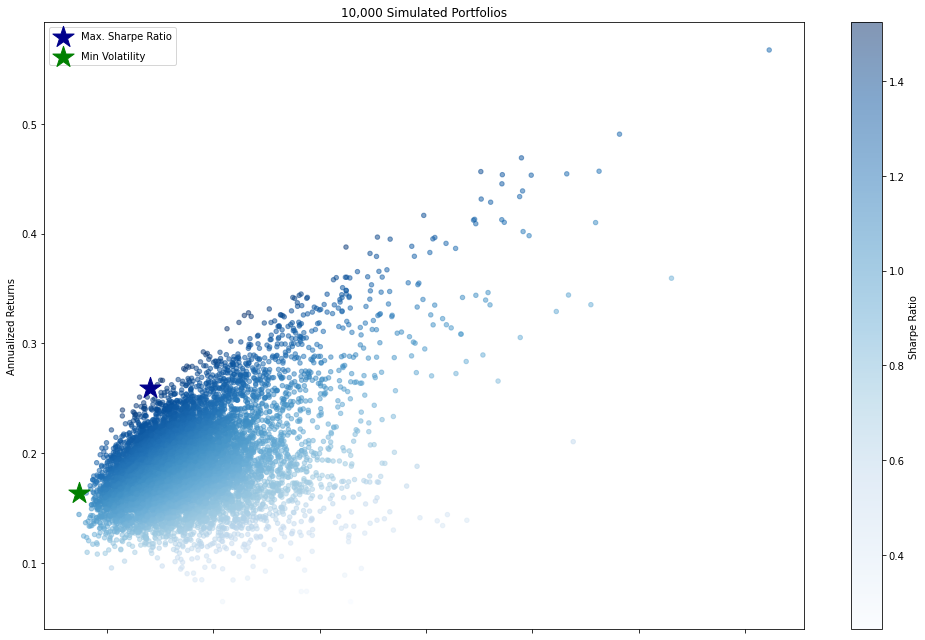

In [66]:
import matplotlib.pyplot as plt

ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{simulations:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

Computation of portfolio volatility and sharpe ratios will require annualization and thus we will have to make a couple methods to annualize "performance" (returns, std).

In [67]:
def portfolio_std(wt, rt=None, cov=None):
    return np.sqrt(wt @ cov @ wt * periods_per_year)

def portfolio_returns(wt, rt=None, cov=None):
    return (wt @ rt + 1) ** periods_per_year - 1

def portfolio_performance(wt, rt, cov):
    r = portfolio_returns(wt, rt, cov)
    std = portfolio_std(wt, rt, cov)
    return r, std

In [68]:
# Find the max Sharpe portfolio

# Since we're going to be using the minimize optimizer, we will actually need to compute negative sharpe ratios for all the portfolios.

def negative_sharpe_ratio(wts, rts, cov):
    r, std = portfolio_performance(wts, rts, cov)
    return -(r - rfr) / std

weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1}

Now we'll run the Markovitz MPT quadratic optimization part. The formula is as follows:

**Minimize:**
$f(\mathbf{w}) = \frac{1}{2} \mathbf{w}^T \Sigma \mathbf{w} - \boldsymbol{\mu}^T \mathbf{w}$

**Subject to:**
$\mathbf{w}^T \mathbf{1} = 1$
$\mathbf{w} \geq 0$

In [69]:
def max_sharpe_portfolio(mean_returns, cov, short=False):
    return minimize(fun=negative_sharpe_ratio,
                    x0=x0,  # initial guess
                    args=(mean_returns, cov_matrix),  # additional args for the objective function
                    method='SLSQP',  # Sequential Least SQuares Programming
                    bounds=((-1 if short else 0, 1),) * n_assets,  # bounds for each asset weight
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})  # tolerance for termination

In [70]:
# Get max sharpe portfolio

max_sharpe_pf = max_sharpe_portfolio(mean_returns, cov_matrix, short=False)
r, std = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)
pd.Series({'ret': r, 'std': std, 'sharpe': (r - rfr) / std})

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_58770/2733858926.py:2: OptimizeWarning: Unknown solver options: tol
  return minimize(fun=negative_sharpe_ratio,


ret       0.349070
std       0.181567
sharpe    1.920306
dtype: float64

In [75]:
# Find the weights and symbols of the max sharpe portfolio:

max_sharpe_pf_wts = pd.Series(max_sharpe_pf.x, index=mean_returns.index)
max_sharpe_pf_wts[max_sharpe_pf_wts.abs() < 1e-4] = 0
max_sharpe_pf_wts[max_sharpe_pf_wts.abs() > 0].sort_values(ascending=False)

print(max_sharpe_pf_wts[max_sharpe_pf_wts.abs() > 0].sort_values(ascending=False))

print("Sanity Check:")
print(f"Sum of Portfolio Weights: {max_sharpe_pf_wts.sum():.2%}")

LLY     0.225516
LMT     0.150607
AVGO    0.139362
TMO     0.093467
TSLA    0.074545
NFLX    0.063613
NEE     0.062881
TMUS    0.060395
NVDA    0.058512
UNH     0.040524
COST    0.030578
dtype: float64
Sanity Check:
Sum of Portfolio Weights: 100.00%


In [76]:
# Minimum volatility portfolio

def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,  # objective function
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [77]:
min_vol_pf = min_vol(mean_returns, cov_matrix)
r, std = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)
pd.Series({'ret': r, 'std': std, 'sharpe': (r - rfr) / std})

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_58770/1398038769.py:6: OptimizeWarning: Unknown solver options: tol
  return minimize(fun=portfolio_std,  # objective function


ret       0.134981
std       0.121621
sharpe    1.106522
dtype: float64

In [79]:
# Find the weights and symbols of the min volatility portfolio:

min_vol_pf_wts = pd.Series(min_vol_pf.x, index=mean_returns.index)
min_vol_pf_wts[min_vol_pf_wts.abs() < 1e-4] = 0
min_vol_pf_wts[min_vol_pf_wts.abs() > 0].sort_values(ascending=False)

print(min_vol_pf_wts[min_vol_pf_wts.abs() > 0].sort_values(ascending=False))
print("Sanity Check:")
print(f"Sum of Portfolio Weights: {min_vol_pf_wts.sum():.2%}")

VZ       0.146713
WMT      0.130952
MCD      0.101407
JNJ      0.091979
CL       0.088001
DUK      0.085903
MRK      0.082856
PG       0.065548
AMZN     0.033010
DHR      0.031099
BMY      0.029012
GILD     0.019558
XOM      0.018640
SBUX     0.014778
TMUS     0.013617
LLY      0.011066
UPS      0.008454
ORCL     0.006216
TXN      0.005603
PEP      0.004324
CMCSA    0.004230
ADBE     0.004224
QCOM     0.002515
MO       0.000296
dtype: float64
Sanity Check:
Sum of Portfolio Weights: 100.00%


Unsurprisingly, the min-vol portfolio is considerably more diversified than the max-sharpe portfolio.

The real question is: does this actually matter and is any of it useful? Well, as is, no (in my opinion). However, I do think there are a couple of ways MVO could be made better:

1. Input your own expected returns (based on your own research or using another model as input)

2. Min vol portfolios might actually be useful for a long-short straddle strategy on different portfolios... this would require some testing to see if the historically-suggested MVO min-vol port is actually min-vol ex-ante. I would be skeptical. It would also require a substantial amount of capital, extremely high transaction costs, and a lot of historical options data (because arbitrarily-weighted S&P 100 portfolios are not available).

3. We could possibly plot the trailing volatility of the actual S&P 100 and continuously rebalance between a max-Sharpe S&P 100 in low-vol, min-variance in high-vol, and ordinary S&P 100 in normal vol.
    - Parameters:
    - (1) Lookback period for MVO and portfolio optimization
    - (2) Volatility floor
    - (3) Volatility ceiling

    For the sake of minimizing transaction costs, it may be wise to do two things:
        - (1) Smart-Rebalance where you compute the diff between your current and your theo portfolio rather than starting from scratch each time (pretty obvious)
        - (2) Inputting in some manner transaction costs to the optimization function... I'm not quite sure how this can be done

    It would also be necessary to have some notion of attribution for excess returns (if this portfolio outperforms) - i.e. is is heavily weighted to min-variance portfolio making you more money or the max-sharpe...

4. Now that I'm thinking of it, I don't really understand why short-S&P long-Reweighted(S&P) is not more commonly spoke of... if seems like you could probably generate fairly consistent 'idiosyncratic' (meaning unique to the outperformance of the reweighted portfolio, not to any particular stock) alpha that isn't excessively tied to market returns by doing this. Will probably test it out in later notebooks.